# GM 9: Convolutional Neural Networks

In [1]:
# Typical libraries for data science
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphing

# Pytorch
import torch
import torchvision
# transform is used to convert data into Tensor form with transformations
import torchvision.transforms as transforms

# libraries to generate Random Subset & dataLoader to feed Batch of data to model, as feeding whole dataset may lead to System failure or Hang
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

# this will help us to create Grid of images
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

# About data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

# Data Normalization

In Neural Network we have to perform Data Normalization to reduce possibility of Over Fitting, also CNN algorithms use Gradient boosting, So its must to perform Normalization else some variable may be given higher weightage.

In [2]:
trans = transforms.Compose([
    # To resize image
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    # To normalize image
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.FashionMNIST(
root = './data',
train = True,
download = True,
transform = trans
)

test_set = torchvision.datasets.FashionMNIST(
root = './data',
train = False,
download = True,
transform = trans
)

len(train_set), len(test_set)

(60000, 10000)

Lets observe some changes

In [3]:
img, label = train_set[0]
img.shape, label

(torch.Size([1, 32, 32]), 9)

So now we have images with 32*32 pixels

In [4]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

As torch has image representation as [color channel, Height, Width] but Maplotlib accepts [height, width, color channel], hence above .permute() function does that.

Label:  9


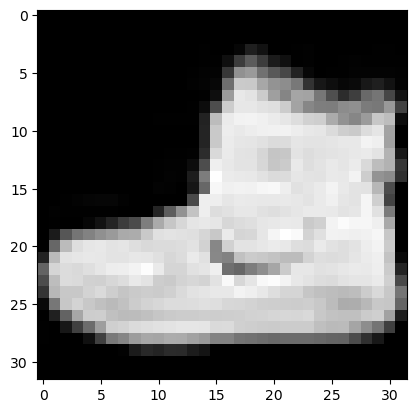

In [5]:
show_img(*train_set[0])

Label:  6


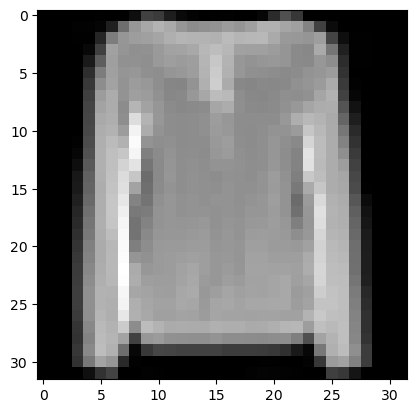

In [6]:
show_img(*train_set[9999])

Label:  1


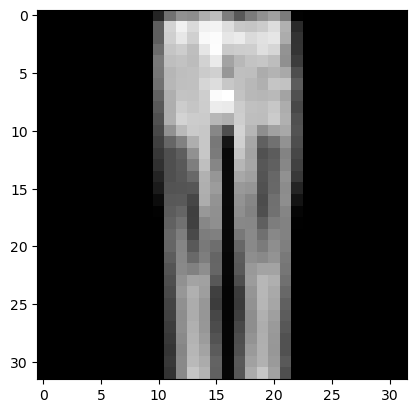

In [7]:
show_img(*test_set[5499])

# Train & Validation data Split

In [8]:
# this function will generate random indexes between 0 and 59999
def split_indices(n, val_per, seed = 0):
    n_val = int(n * val_per)
    np.random.seed(seed)
    idx = np.random.permutation(n)
    return idx[n_val : ], idx[: n_val]


val_per = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(train_set), val_per, rand_seed)

print(len(train_indices), len(val_indices))

48000 12000


In [9]:
# Lets plot some indexes
print("Validation Indices: ", val_indices[:20])
print("Training Indices: ", train_indices[:20])

Validation Indices:  [12628 37730 39991  8525  8279 51012 14871 15127  9366 33322 53390 21819
  5026 23428 45297 26354 30195 47038 20731 34047]
Training Indices:  [48572 38696 13611 35213 31766 57477  9165 21399 44113 55436 33761  2417
 10339 21794 59625 38542 10557  4120 46651 59905]


It seems indexes are distributed across range as provided

In [10]:
# this is one of Hyper parameter, but let's select given below value
batch_size = 512

# training data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(train_set, batch_size, sampler = train_sampler)

# validation dataloader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(train_set, batch_size, sampler = val_sampler)

Let's verify where we have all class from output columns in both train and validation set



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


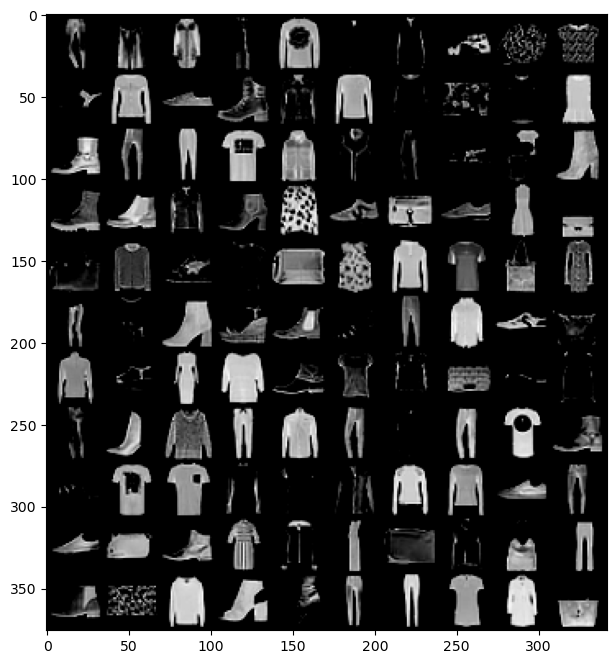

In [11]:
# We will select first 110 image from first batch of size = 512
def show_batch(dl):
    for img, label in dl:
        fig, ax = plt.subplots(figsize = (12,8))
        ax.imshow(make_grid(img[:110], 10).permute(1,2,0))
        break
        
show_batch(val_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


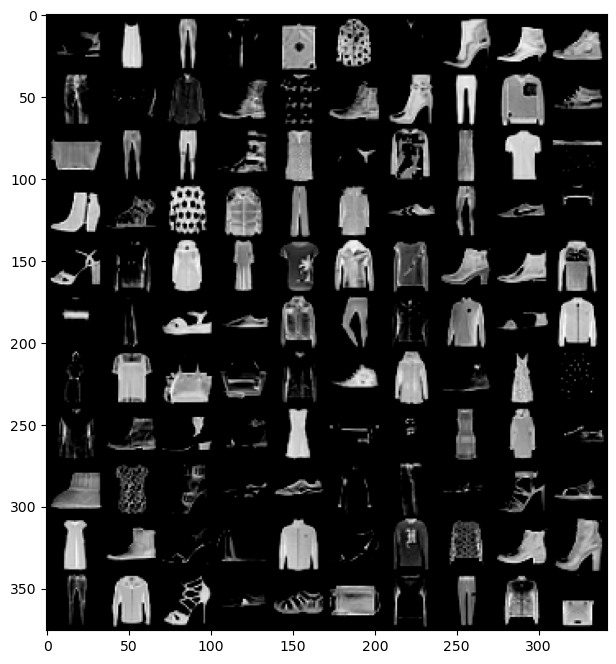

In [12]:
show_batch(train_dl)

Images seems equally Distributed



# Model Building using Torch.nn

This is how Yen LeKun has decribed and built First Neural network in 1988, that was probably first working Neural model

In [13]:
class LeNet5(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.num_classes = num_classes
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)  
        )
        
        
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logit = self.classifier(x)
        return logit

In [14]:
# Load Model
model = LeNet5(num_classes = 10)

display(model)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Let's test model based on initial Guesses by Pytorch



In [15]:
sample = next(iter(train_set))
img = sample[0]
out = model(img.unsqueeze(0))
# Output In terms of Probability
F.softmax(out)

/var/folders/_m/ks1gwkm54b11rrjtc9mp49t80000gr/T/ipykernel_50263/1573464512.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(out)


tensor([[0.1001, 0.0889, 0.1067, 0.0910, 0.1109, 0.0911, 0.1099, 0.0960, 0.0983,
         0.1070]], grad_fn=<SoftmaxBackward0>)

Initial guess from model suggest, probability of each class as 10%, which is kind of 1st prediction from model



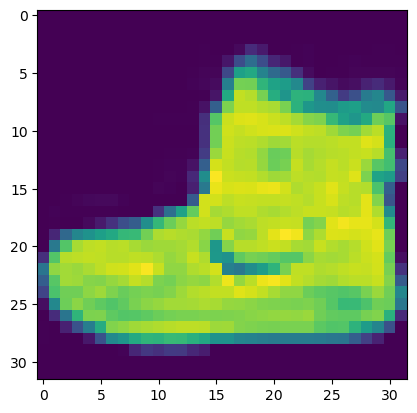

In [16]:
# Lets plot
plt.imshow(img.permute(1,2,0))

Well, it was wrong guess from Model :(

# Device Selection

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

As we are using GPU, so below code will help us to access GPU at different stage of Processing



In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

# Define Helper Fit Model

In [20]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    
    pred = model(x)
    
    loss = loss_func(pred, y)
    
    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    
    if metric is not None:
        
        metric_result = metric(pred, y)
        
    return loss.item(), len(x), metric_result



def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric



def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    
    train_losses, val_losses, val_metrics, train_metrics = [], [], [], []
    
    
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            train_loss, _, train_metric = loss_batch(model, loss_fn, x, y, opt_fn, metric)
            
        model.eval()
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        train_metrics.append(train_metric)
        
        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                 .format(epoch+1, epochs, train_loss, val_loss))
            
        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}, train_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric, metric.__name__, train_metric))
            
        if scheduler is not None:
            if scheduler_on == 'val_metric':
                scheduler.step(val_metrics[-1])
        
            
    return train_losses, val_losses, val_metrics, train_metrics

Define Accuracy function

In [21]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

Initial guess on Validation data

In [22]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print("Initial Validation Losses: {}, Accuracy: {}".format(val_loss, val_acc))

Initial Validation Losses: 2.304145725250244, Accuracy: 0.097


In [23]:
num_epochs = 25

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)

In [24]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Epoch 1/25, train_loss: 0.5599, val_loss: 0.5587, val_accuracy: 0.7860, train_accuracy: 0.7786
Epoch 2/25, train_loss: 0.5171, val_loss: 0.4298, val_accuracy: 0.8450, train_accuracy: 0.8021
Epoch 3/25, train_loss: 0.3642, val_loss: 0.3872, val_accuracy: 0.8561, train_accuracy: 0.8672
Epoch 4/25, train_loss: 0.3729, val_loss: 0.3546, val_accuracy: 0.8700, train_accuracy: 0.8516
Epoch 5/25, train_loss: 0.3074, val_loss: 0.3347, val_accuracy: 0.8798, train_accuracy: 0.8984
Epoch 6/25, train_loss: 0.3291, val_loss: 0.3296, val_accuracy: 0.8800, train_accuracy: 0.8594
Epoch 7/25, train_loss: 0.4202, val_loss: 0.3217, val_accuracy: 0.8837, train_accuracy: 0.8411
Epoch 8/25, train_loss: 0.2800, val_loss: 0.3272, val_accuracy: 0.8807, train_accuracy: 0.8958
Epoch 9/25, train_loss: 0.2554, val_loss: 0.3042, val_accuracy: 0.8906, train_accuracy: 0.8880
Epoch 10/25, train_loss: 0.2391, val_loss: 0.3238, val_accuracy: 0.8816, train_accuracy: 0.9010
Epoch 11/25, train_loss: 0.2763, val_loss: 0.2915

# Plotting result

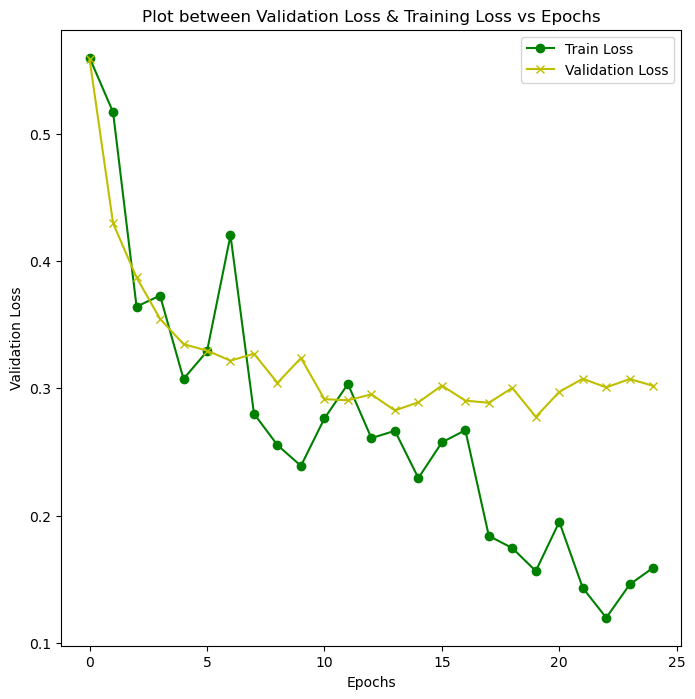

In [25]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-go')
plt.plot(history[1], '-yx')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss & Training Loss vs Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')

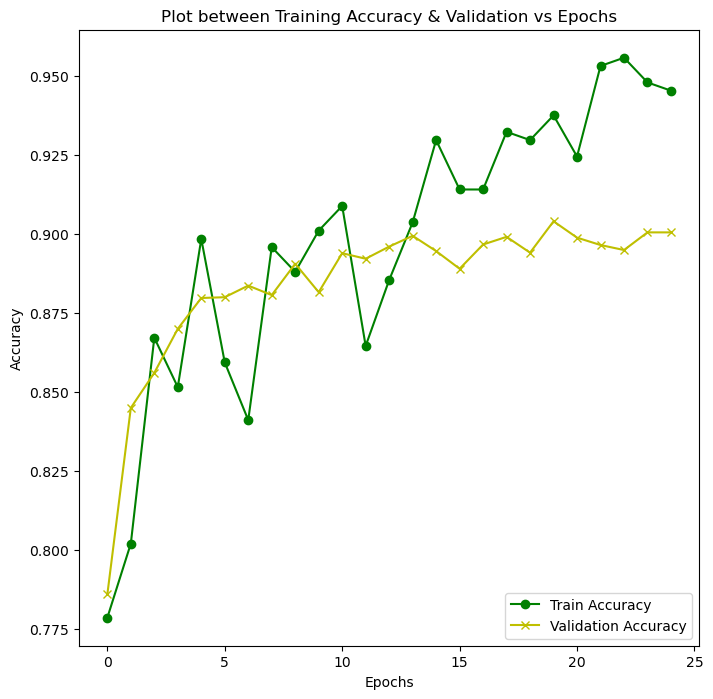

In [26]:
plt.figure(figsize = (8,8))
plt.plot(history[3], '-go')
plt.plot(history[2], '-yx')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot between Training Accuracy & Validation vs Epochs')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')

# Test data & Model Evaluation

In [27]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


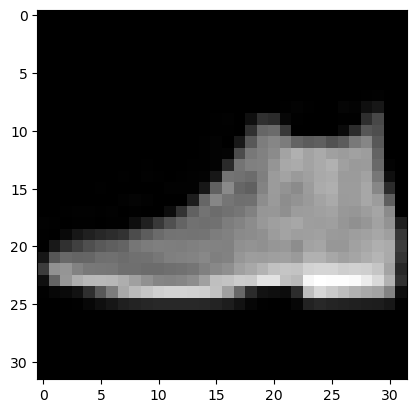

In [28]:
img, label = test_set[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


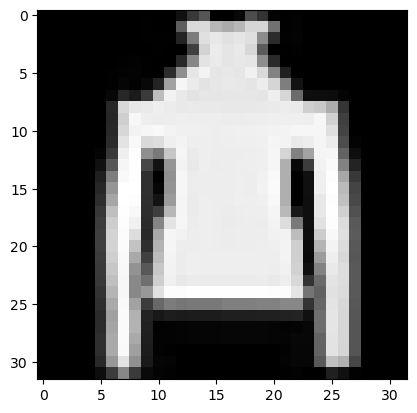

In [29]:
img, label = test_set[1539]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


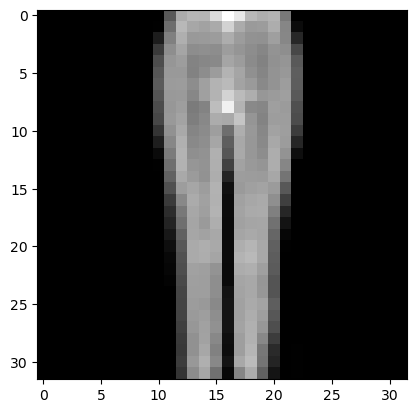

In [30]:
img, label = test_set[1903]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 6


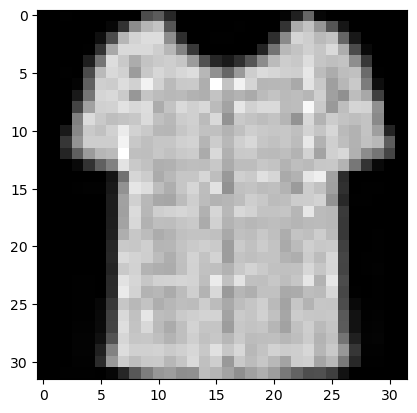

In [31]:
img, label = test_set[1000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## As a final step, let's also look at the overall loss and accuracy of the model on the test set.



In [32]:
test_loader = DeviceDataLoader(DataLoader(test_set, batch_size=256), device)
result = evaluate(model, F.cross_entropy, test_loader, metric = accuracy)
result
Accuracy = result[2] * 100
Accuracy
loss = result[0]
print("Total Losses: {}, Accuracy: {}".format(loss, Accuracy))

Total Losses: 0.3243789147615433, Accuracy: 88.98
